# Вариант 10.В

## О чём работа в блокноте

Обобщенное распределение Лапласа со следующим значением параметра $n=4$.

$$
f(x,n) = f(x,4) = \frac{e^{-|x|}}{(n-1)!\cdot 16} \sum\limits_{j=0}^{3}\frac{(3+j)!}{(3-j)!\cdot j!} \frac{|x|^{3-j}}{2^{j}} = \
$$

$$
\ = e^{-|x|}\cdot\frac{|x|^{3}+6|x|^{2} + 15|x| + 15}{96}.
$$

Дисперсия: $\sigma^{2}= 8$,

Коэффициент эксцесса: $\large\gamma_{2} = \frac{3}{4}$.


## Как пользоваться блокнотом?

В блокноте будут идти вычисления ТОЛЬКО ПО ОДНОЙ ВЫБОРКЕ (все графики, всё прочее строятся только для одной выборки). Поэтому для того, чтобы получить значения на разных выборках, необходимо менять глобальные параметры, расположенные в блоке кода ниже.

Для того, чтобы быстро перезапустить вычисление во всех ячейках, можно нажать `ctrl+F9`, либо через верхнее меню: `Среда выполнения -> выполнить все`.

In [1]:
# базовые импорты

import math
import statistics
import matplotlib.pyplot as plt

import numpy as np

from scipy import stats as st
from scipy import integrate
from scipy.integrate import quad
from scipy.optimize import minimize

import pandas as pd

# Глобальные параметры
count = 10000 # количество которое хочешь сгенерить
eps = 0.1  # Эпсилон (коэффициент зашумления)

rng = np.random.default_rng(
    12345 # 12345, 23456, 34567
)  # Генератор рандомных чисел с фиксированным сидом (для повторяемости результатов)

# Параметры для чистого распределения
N_net = 4  # Параметр распределения
l_net = 1  # Масштаб (лямбда) НЕ МЕНЯТЬ
O_net = 0  # Смещение (Тетта) НЕ МЕНЯТЬ

# Параметры для шума
N_scattener = N_net  # Параметр распределения
l_scattener = 2  # Масштаб (лямбда). 1 по умолчанию
O_scattener = 4  # Смещение (Тетта). 0 по умолчанию

## 1 Разработка программы

### 1.1. Генерация данных

> Полное задание пункта
> Разработать программу, которая реализует генерацию наборов данных с заданным в варианте *чистым распределением и засоренным распределением*, использовать засоряющие распределения, совпадающие с чистым с точностью до значений параметров сдвига и масштаба.


#### Генерация чистого и загрязняющего распределения

Обобщённое распределение Лапласа с параметром $n=4$ задаётся следующим образом:

$$
f(x) = e^{-|x|}\cdot\frac{|x|^{3}+6|x|^{2} + 15|x| + 15}{96}.
$$

Дисперсия при этом равна $\sigma^{2}=8$, коэффициент эксцесса: $\large\gamma_{2}=\frac{3}{4}$.

Моделирование случайных величин осуществляется по следующей формуле:

$$
x = \ln\left(\frac{\prod\limits_{i:r_{i} \leqslant \frac{1}{2}} 2r_{i}}{\prod\limits_{i: r_{i} > \frac{1}{2}}2(1-r_{i})}\right),
$$

где $r_{i}, i=\{1, \dots, n\}= \{1,2,3,4\}$ – *реализация случайной величины*, равномерно распределённой на интервале $(0; 1)$ (просто 4 значения с генератора равномерных случайных чисел); если нет ни одного элемента, удовлетворяющего условию в произведении, то оно равно 1.

#### Генерация засоряющего распределения

Засоряющее распределение должно (судя по всему) повторять исходное распределение, но также должно иметь возможность изменять свой масштаб и сдвиг.  Сдвиг-масштабное преобразование осуществляется по следующей формуле:

$$
x = \theta + \lambda x_{1},
$$

где $\theta$ – параметр сдвига, $\lambda$ – параметр масштаба, $x_{1}$ – значение случайной величины с нулевым сдвигом и единичным масштабом.

Применимо к формуле нашего распределения, получаем:

$$
x = \theta + \lambda \ln\left(\frac{\prod\limits_{i:r_{i} \leqslant \frac{1}{2}} 2r_{i}}{\prod\limits_{i: r_{i} > \frac{1}{2}}2(1-r_{i})}\right).
$$



In [2]:
def gen_rand_laplas(n_lap: int, theta: float = 0.0, lamb: float = 1.0) -> float:
    """
    Генератор случайной величины, соответствующей обобщенному распределению Лапласа, с возможностью задания сдвига и масштабирования

    Args:
        n_lap (int): Натуральное число, соответствющее количеству случайных величин. Является параметром обобщённого распределения Лапласа `n`
        theta (float, optional): параметр сдвига распределения тэтта. По умолчанию 0.0
        lamb (float, optional): параметр масштабироваиня сдвига лямбда. По умолчанию 1.0

    Returns:
        float: Случайная величина, соответствующая обобщенному распределению Лапласа.
    """
    global rng

    list_rand = rng.random((n_lap,))

    res = 1.0
    for item in list_rand:
        if item <= (1 / 2):
            res *= 2 * item
        else:
            res /= 2 * (1 - item)

    return np.log(res) * lamb + theta


def gen_full_laplas(
    count: int, theta: float = 0.0, lamb: float = 1.0
) -> np.ndarray[np.float64]:
    """Генератор множества случайных величин по распределению Лапласа

    Args:
        count (int): размер выборки случайных чисел по данному распределению
        theta (float, optional): параметр сдвига распределения тэтта. По умолчанию 0.0
        lamb (float, optional): параметр масштабироваиня сдвига лямбда. По умолчанию 1.0

    Returns:
        ndarray[float64]: множество значений полученной выборки
    """
    global N_net

    res = [gen_rand_laplas(N_net, theta=theta, lamb=lamb) for _ in range(count)]
    return np.asarray(res)

print(f"Размер выборки: {count} элементов...")

print("Строим чистое распределение...")
clean = gen_full_laplas(count)

print("Строим загрязняющее распределение...")
scattener = gen_full_laplas(count, theta=O_scattener, lamb=l_scattener)

Размер выборки: 10000 элементов...
Строим чистое распределение...
Строим загрязняющее распределение...


#### Генерация засорённого распределения

Засорённое распределение представляет собой смесь двух распределений с плотностью, задаваемой следующей формулой:

$$
g(x) = (1 - \varepsilon) f(x) + \varepsilon h(x),
$$

где $0 < \varepsilon < 0.5$ – уровень засорения, $f(x), h(x)$ – плотности чистого и засоряющего распределений соответственно.

Моделирование случайной величины с засорённым распределением можно проводить по следующему алгоритму:

1. Сгенерировать случайное число $r$, равномерно распределённое на интервале $(0; 1)$. Если $r \leqslant 1 - \varepsilon$, перейти на шаг 2, иначе перейти на шаг 3.
2. Сгенерировать случайное число с плотностью $f(x)$ (чистое распределение). Оно и будет искомым числом.
3. Сгенерировать случайное число с плотностью $h(x)$ (загрязняющее распределение). Оно и будет искомым числом.

In [3]:
def get_scattened_laplas(
    clean: np.ndarray[np.float64], scattener: np.ndarray[np.float64], eps: float
) -> np.ndarray[np.float64]:
    """Соединяет чистое и загрязняющее распределения в единое загрязнённое

    Args:
        clean (np.ndarray[np.float64]): множество случайных величин из чистого распределения
        scattener (np.ndarray[np.float64]): множество случайных величин из загрязняющего распределения (должно совпадать по размеру с чистым)
        eps (float): коэффициент загрязнения (0 <= `eps` <= 0.5)

    Returns:
        np.ndarray[np.float64]: полученное загрязнённое распределение
    """
    global rng
    res = np.zeros_like(clean)
    rand = rng.random((clean.size,))

    for ind in range(res.size):
        if rand[ind] <= (1 - eps):
            res[ind] = clean[ind]
        else:
            res[ind] = scattener[ind]

    return res

scattened = get_scattened_laplas(clean, scattener, eps)

#### Вывод графиков



Графики функций плотности полученных распределений
Чистое распределение: Тетта = 0, Лямбда = 1
Загрязняющее распределение: Тетта = 4, Лямбда = 2


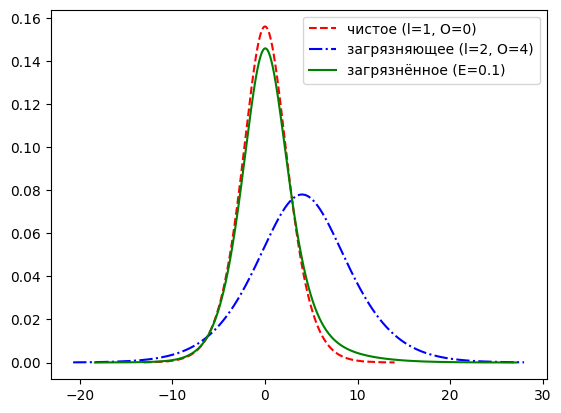

In [4]:
def f_laplas(data: np.ndarray, theta: float = 0.0, lamb: float = 1.0) -> np.ndarray:
    """
    Функция плотности распределения Лапласа от значений X

    Args:
        data (np.ndarray): значения X текущего распределения (желательно должна быть отсортированной)
        theta (float): значение параметра сдвига функции (по умолчанию 0)
        lamb (float): значение параметра масштабирования функции (по умолчанию 1)

    Returns:
        np.ndarray: значения функции плотности распределения Лапласа
    """
    ordered = np.sort(data) # Сортируем последовательность
    ordered = (ordered - theta) / lamb # Убираем сдвиги
    ordered = np.abs(ordered) # Убираем знаки значений

    result = np.exp(-1 * ordered)
    result *= (ordered**3 + 6 * ordered**2 + 15*ordered + 15) / (96 * lamb)
    return result

def f_laplas_mixed(mixed: np.ndarray) -> np.ndarray:
    """
    Функция плотности смешанного распределения от значений X чистого и загрязняющего распределений

    Args:
        mixed (np.ndarray): значения X смешанного распределения

    Returns:
        np.ndarray: значения функции плотности смешанного распределения Лапласа
    """
    mixed_sorted = np.sort(mixed) # Сортируем последовательность
    f_clean = f_laplas(mixed_sorted, O_net, l_net)
    f_scattener = f_laplas(mixed_sorted, O_scattener, l_scattener)

    return (1 - eps) * f_clean + eps * f_scattener

def plot_graphics(
    clean: np.ndarray[np.float64],
    scattener: np.ndarray[np.float64],
    scattened: np.ndarray[np.float64],
):
    """Выводит графики сгенерированных распределений на экран (приводя размеры к единичному по графику `clean`)

    Args:
        clean (np.ndarray[np.float64]): массив значений из чистого распределения
        scattener (np.ndarray[np.float64]): массив значений из загрязняющего распределения
        scattened (np.ndarray[np.float64]): массив значений из грязного распределения
    """
    step = 1
    if clean.size > 10000:
        step = int(clean.size / 5000)
    clean_sorted = np.sort(clean)[::step]
    scattener_sorted = np.sort(scattener)[::step]
    scattened_sorted = np.sort(scattened)[::step]

    f_clean = f_laplas(clean_sorted, O_net, l_net)
    f_scattener = f_laplas(scattener_sorted, O_scattener, l_scattener)
    f_scattened = f_laplas_mixed(scattened_sorted)

    # Выводим полученные графики
    fig, axes = plt.subplots()
    axes.plot(clean_sorted, f_clean, label=f"чистое (l={l_net}, O={O_net})", linestyle="--", color="red")
    axes.plot(scattener_sorted, f_scattener, label=f"загрязняющее (l={l_scattener}, O={O_scattener})", linestyle="-.", color="blue")
    axes.plot(scattened_sorted, f_scattened, label=f"загрязнённое (E={eps})", linestyle="-", color="green")
    # axes.plot([10.0, 10.0], [0.0, 1.1], label="Центр", color="purple")
    axes.legend()

    plt.show()

print("Графики функций плотности полученных распределений")
print(f"Чистое распределение: Тетта = {O_net}, Лямбда = {l_net}")
print(f"Загрязняющее распределение: Тетта = {O_scattener}, Лямбда = {l_scattener}")
plot_graphics(clean, scattener, scattened)

### 1.4. Вычисление математического ожидания, дисперсии, коэффициентов асимметрии и эксцесса случайной величины с засоренным распределением по заданным характеристикам чистого и засоряющего распределений

Для того, чтобы получить значения данных характеристик для загрязнённого распределения, надо найти их для чистого и загрязняющего. Ищуются они по следующим формулам:

$$
M = 0 + \theta,
$$

$$
D = \sigma^{2} = 2\cdot n \cdot \lambda^{2},
$$

$$
\gamma_{1} = 0, ???
$$

$$
\gamma_{2} = \frac{3}{n}.
$$


In [5]:
dataframe_labels = [
    "Мат ожидание М",
    "Дисперсия D",
    "Ассиметрия gamma_1",
    "Эксцесс gamma_2",
]

# Теоретические величины
M1_ = 0 + O_net            # Матожидание
D1_ = 2 * N_net * l_net**2 # Дисперсия
G11_ = 0                   # Ассиметрия
G12_ = 3 / N_net           # Эксцесс

print(f"Для чистого распределения ({count} точек):")
pd.DataFrame(np.array([dataframe_labels, [M1_, D1_, G11_, G12_]]).T, columns=["Параметр чистого", "Значение"])

Для чистого распределения (10000 точек):


,Параметр чистого,Значение
0,Мат ожидание М,0
1,Дисперсия D,8
2,Ассиметрия gamma_1,0
3,Эксцесс gamma_2,0.75


In [6]:
# Теоретические величины
M2_ = 0 + O_scattener                  # Матожидание
D2_ = 2 * N_scattener * l_scattener**2 # Дисперсия
G21_ = 0 # Ассиметрия
G22_ = 3 / N_scattener # Эксцесс

print(f"Для загрязняющего распределения ({count} точек):")
pd.DataFrame(np.array([dataframe_labels, [M2_, D2_, G21_, G22_]]).T, columns=["Параметр загрязняющего", "Значение"])

Для загрязняющего распределения (10000 точек):


,Параметр загрязняющего,Значение
0,Мат ожидание М,4
1,Дисперсия D,32
2,Ассиметрия gamma_1,0
3,Эксцесс gamma_2,0.75


Для вычисления всяких там параметров полученного засорённого распределения можно воспользоваться следующими формулами. Обозначим $M_{i}, D_{i}, \gamma_{2i}, i=1,2$ мат ожидание, дисперсию и коэффициент эксцесса, соответствующие при $i=1$ и $i=2$ плотностям $f(x)$ и $h(x)$. Тогда матожидание, дисперсия, коэффициенты асимметрии и эксцесса случайной величины с засорённым распределением выражается формулами:

$$
M = (1-\varepsilon)M_{1} + \varepsilon M_{2},
$$

$$
D = (1 - \varepsilon)(M_{1}^{2} + D_{1}) + \varepsilon(M_{2}^{2} + D_{2}) - M^{2},
$$

$$
\gamma_{1} = \frac{1}{D^{1.5}} \left[(1 - \varepsilon) \left\{(M_{1} - M)^{3} + 3(M_{1} - M)D_{1}\right\} + \varepsilon \left\{(M_{2}-M)^{3} + 3(M_{2}-M)D_{2} \right\} \right],
$$

$$
\gamma_{2} = \frac{1}{D^{2}} \left\{ (1-\varepsilon) \left[ (M_{1} - M)^{4} + 6(M_{1} - M)^{2}D_{1} + D_{1}^{2}(\gamma_{21} + 3) \right] + \ \right.
$$

$$
\ + \left. \varepsilon [(M_{2}-M)^{4} +6(M_{2}-M)^{2}D_{2} + D_{2}^{2}(\gamma_{22} + 3) ] \right\} - 3.
$$

In [7]:
# Теоретические величины
M_ = (1 - eps) * M1_ + eps * M2_
D_ = (1 - eps) * (M1_**2 + D1_) + eps * (M2_**2 + D2_) - M_**2
G1_ = (1 / D_**1.5) * (
    (1 - eps) * ((M1_ - M_) ** 3 + 3 * (M1_ - M_) * D1_)
    + eps * ((M2_ - M_) ** 3 + 3 * (M2_ - M_) * D2_)
)
G2_ = (1 / D_**2) * (
    (1 - eps) * ((M1_ - M_)**4 + 6 * (M1_ - M_)**2 * D1_ + D1_**2 * (G12_ + 3))
        + eps * ((M2_ - M_)**4 + 6 * (M2_ - M_)**2 * D2_ + D2_**2 * (G22_ + 3))
) - 3

print(f"Для загрязнённого распределения ({count} точек):")
pd.DataFrame(
    np.array([dataframe_labels, [M_, D_, G1_, G2_]]).T,
    columns=["Параметр загрязнённого", "Значение"],
)

Для загрязнённого распределения (10000 точек):


,Параметр загрязнённого,Значение
0,Мат ожидание М,0.4
1,Дисперсия D,11.84
2,Ассиметрия gamma_1,0.7493259956865109
3,Эксцесс gamma_2,3.2243425858290733


### 1.2. Вычисление выборочных характеристик полученных распределений

Здесь фактически совпадёт со 2 пунктом, поэтому пропускаю

## 2 Провести проверку генератора чистого и засорённого распределений

Выборочные характеристики считаются следующим образом:

|Название|Формула|Функция|
|---|:---:|---|
|Среднее арифметическое $M$ | $\frac{1}{N}\sum\limits_{i=1}^{N}y_{i}$ | `numpy.mean(array) -> float` |
|Медиана $m$ | тю-тю (просто средний элемент) | `numpy.median(array) -> float` |
|Дисперсия $D$ | $\frac{1}{N}\sum\limits_{i=1}^{N}(y_{i}-M)^{2}$ | `numpy.var(array) -> float` |
|Коэф. асимметрии $\gamma_1$| $\frac{\sum\limits_{i=1}^{N} (y_{i} - \bar{y})^{3}}{N \cdot D^{1.5}}$ |`scipy.stats.skew(array) -> float`|
|Коэф. эксцесса $\gamma_2$|$\frac{\sum\limits_{i=1}^{N}(y_{i} - \hat{y})^{4}}{N\cdot D^{2}} - 3$|`scipy.stats.kurtosis(array) -> float`|

Для чистого и загрязняющего распределений, медиана равна $0$ и $\theta$ соответственно в силу их симметричности. Для загрязнённого распределения, в силу его возможной несимметричности, теоретическую медиану найти неизвестно как.


In [8]:
dataframe_labels = [
    "Мат ожидание М",
    "Медиана m",
    "Дисперсия D",
    "Ассиметрия gamma_1",
    "Эксцесс gamma_2",
]

# Практические величины
PM1_ = np.mean(clean)      # Матожидание
Pm1_ = np.median(clean)    # Медиана
PD1_ = np.var(clean)       # Дисперсия
PG11_ = st.skew(clean)     # Ассиметрия
PG12_ = st.kurtosis(clean) # Эксцесс

print(f"Теоретические и практические величины для чистого распределения ({count} точек)")
pd.DataFrame(
    np.array([
        dataframe_labels,
        [M1_, M1_, D1_, G11_, G12_],
        [PM1_, Pm1_, PD1_, PG11_, PG12_],
    ]).T,
    columns=["Параметр чистого", "Теоретические", "Практические"],
)

Теоретические и практические величины для чистого распределения (10000 точек)


,Параметр чистого,Теоретические,Практические
0,Мат ожидание М,0,-0.002384357223356642
1,Медиана m,0,-0.0012890098795986563
2,Дисперсия D,8,8.060425043576158
3,Ассиметрия gamma_1,0,-0.027832931613102116
4,Эксцесс gamma_2,0.75,0.6979550465265616


In [9]:
# Практические величины
PM2_ = np.mean(scattener)      # Матожидание
Pm2_ = np.median(scattener)    # Медиана
PD2_ = np.var(scattener)       # Дисперсия
PG21_ = st.skew(scattener)     # Ассиметрия
PG22_ = st.kurtosis(scattener) # Эксцесс

print(f"Теоретические и практические величины для загрязняющего распределения ({count} точек)")
pd.DataFrame(
    np.array([
        dataframe_labels,
        [M2_, M2_, D2_, G21_, G22_],
        [PM2_, Pm2_, PD2_, PG21_, PG22_],
    ]).T,
    columns=["Параметр загрязняющего", "Теоретические", "Практические"],
)

Теоретические и практические величины для загрязняющего распределения (10000 точек)


,Параметр загрязняющего,Теоретические,Практические
0,Мат ожидание М,4,4.078487850551322
1,Медиана m,4,4.049179841144411
2,Дисперсия D,32,32.09559396418045
3,Ассиметрия gamma_1,0,-0.0006401434403831241
4,Эксцесс gamma_2,0.75,0.6899264427295502


In [10]:
dataframe_labels = [
    "Мат ожидание М",
    "Дисперсия D",
    "Ассиметрия gamma_1",
    "Эксцесс gamma_2",
]

# Практические величины
PM_ = np.mean(scattened)      # Матожидание
PD_ = np.var(scattened)       # Дисперсия
PG1_ = st.skew(scattened)     # Ассиметрия
PG2_ = st.kurtosis(scattened) # Эксцесс

print(f"Теоретические и практические величины для загрязнённого распределения ({count} точек)")
pd.DataFrame(
    np.array([
        dataframe_labels,
        [M_, D_, G1_, G2_],
        [PM_, PD_, PG1_, PG2_],
    ]).T,
    columns=["Параметр загрязнённого", "Теоретические", "Практические"],
)

Теоретические и практические величины для загрязнённого распределения (10000 точек)


,Параметр загрязнённого,Теоретические,Практические
0,Мат ожидание М,0.4,0.43937800097972796
1,Дисперсия D,11.84,12.282193326789393
2,Ассиметрия gamma_1,0.7493259956865109,0.7748304423297859
3,Эксцесс gamma_2,3.2243425858290733,3.0800725863169998


## 3 Для выборок с разными видами распределений вычислить следующие оценки параметра сдвига:

### 3.1. Среднее арифметическое

Само среднее арифметическое выглядит следующим образом:

$$
M = \frac{1}{N}\sum\limits_{i=1}^{N}y_{i}.
$$

Среднее арифметическое является М-оценкой параметра сдвига $\theta$ с функцией потерь

$$
\rho(y, \theta) = (y - \theta)^{2}.
$$

Для нахождения параметра сдвига необходимо решить следующую задачу минимизации:

$$
Q(\theta) = \frac{1}{N}\sum\limits_{i=1}^{N} (y_{i} - \theta)^{2} \rightarrow \min
$$

В нашем случае (видимо из-за симметричности распределения и того, что по умолчанию матожидание равно 0), для нахождения параметра сдвига по среднему арифметическому достаточно просто посчитать среднее арифметическое.

In [11]:
def theta_approximation_by_mean(data: np.ndarray) -> float:
    """
    Функция оценки параметра сдвига при помощи среднего арифметического

    Args:
        data (np.ndarray): последовательность, для которой необходимо выполнить оценку

    Returns:
        float: значение оценки параметра
    """
    return np.mean(data)

theta_by_mean = theta_approximation_by_mean(scattened)
print(f"Параметр сдвига по методу среднего арифметического: {theta_by_mean}")

Параметр сдвига по методу среднего арифметического: 0.43937800097972796


### 3.2. Выборочная медиана

Выборочная медиана также является М-оценкой, но проще найти параметр сдвига через само значение медианы

In [12]:
def theta_approximation_by_median(data: np.ndarray) -> float:
    """
    Функция оценки параметра сдвига при помощи медианы

    Args:
        data (np.ndarray): последовательность, для которой необходимо выполнить оценку

    Returns:
        float: значение оценки параметра
    """
    return np.median(data)

theta_by_median = theta_approximation_by_median(scattened)
print(f"Параметр сдвига по методу медианы: {theta_by_median}")

Параметр сдвига по методу медианы: 0.2111281797746437


### 3.3. Усечённое среднее

Для оценки параметра сдвига при помощи усечённого среднего можно воспользоваться `scipy.stats.trim_mean(array, alpha: float) -> float`. Необходимо будет также сделать 3 таких оценки с коэффициентами $0.05$, $0.10$, $0.15$.

In [13]:
def theta_approximation_by_trim_mean(data: np.ndarray, alpha: float) -> float:
    """
    Функция оценки параметра сдвига при помощи усечённого среднего

    Args:
        data (np.ndarray): последовательность, для которой необходимо выполнить оценку
        alpha (float): процент усечения диапазона (от 0.0 до 0.5)

    Returns:
        float: значение оценки параметра
    """
    return st.trim_mean(data, alpha)

theta_by_trim_mean_05 = theta_approximation_by_trim_mean(scattened, 0.05)
theta_by_trim_mean_10 = theta_approximation_by_trim_mean(scattened, 0.10)
theta_by_trim_mean_15 = theta_approximation_by_trim_mean(scattened, 0.15)
print(f"Параметр сдвига по методу усечённого среднего (alpha = 0.05): {theta_by_trim_mean_05}")
print(f"Параметр сдвига по методу усечённого среднего (alpha = 0.10): {theta_by_trim_mean_10}")
print(f"Параметр сдвига по методу усечённого среднего (alpha = 0.15): {theta_by_trim_mean_15}")

Параметр сдвига по методу усечённого среднего (alpha = 0.05): 0.31534016355486966
Параметр сдвига по методу усечённого среднего (alpha = 0.10): 0.27612234899386967
Параметр сдвига по методу усечённого среднего (alpha = 0.15): 0.2539077012659453


### 3.4. Метод максимального правдоподобия

Для оценки максимального правдоподобия необходимо провести минимизацию функционала вида

$$
Q(\theta) = \frac{1}{N} \sum\limits_{i=1}^{N} -\ln f\left(\frac{y-\theta}{\lambda}\right),
$$

где $f$ – функция плотности распределения Лапласа без смещений и прочего.

In [14]:
def theta_approximation_by_MLE(data: np.ndarray) -> float:
    """
    Функция оценки параметра сдвига при помощи метода максимального правдоподобия

    Args:
        data (np.ndarray): последовательность, для которой необходимо выполнить оценку

    Returns:
        float: значение оценки параметра
    """
    f = lambda O, x: np.sum(-np.log(f_laplas(x - O)))
    return minimize(f, x0=0, args=(data), tol=1e-6).x[0]

theta_by_MLE = theta_approximation_by_MLE(scattened)
print(f"Параметр сдвига по методу максимального правдоподобия: {theta_by_MLE}")

Параметр сдвига по методу максимального правдоподобия: 0.30174409259334023


### 3.5. Метод обобщённых радикальных оценок

Обобщённые радикальные оценки задаются следующей функцией потерь:

$$
\rho(y, \theta) = - \frac{1}{f^{\delta}(0)}f^{\delta}\left( \frac{y-\theta}{\lambda} \right),
$$

где $\delta > 0$ – параметр, регулирующий степень робастности оценки.

In [15]:
def theta_approximation_by_MGD(data: np.ndarray, delta: float) -> float:
    """
    Функция оценки параметра сдвига при помощи метода обобщённых радикальных оценок

    Args:
        data (np.ndarray): последовательность, для которой необходимо выполнить оценку
        delta (float): параметр робастности оценки

    Returns:
        float: значение оценки параметра
    """
    f0 = 15/96
    f = lambda O, x: np.sum(-1 / (f0**delta) * f_laplas(x - O)**delta)
    return minimize(f, x0=0, args=(data), tol=1e-6).x[0]

theta_by_MGD_01 = theta_approximation_by_MGD(scattened, 0.1)
theta_by_MGD_05 = theta_approximation_by_MGD(scattened, 0.5)
theta_by_MGD_10 = theta_approximation_by_MGD(scattened, 1.0)
print(f"Параметр сдвига по методу обобщённых радикальных оценок (параметр = 0.1): {theta_by_MGD_01}")
print(f"Параметр сдвига по методу обобщённых радикальных оценок (параметр = 0.5): {theta_by_MGD_05}")
print(f"Параметр сдвига по методу обобщённых радикальных оценок (параметр = 1.0): {theta_by_MGD_10}")

Параметр сдвига по методу обобщённых радикальных оценок (параметр = 0.1): 0.24048915811687807
Параметр сдвига по методу обобщённых радикальных оценок (параметр = 0.5): 0.13606941961901564
Параметр сдвига по методу обобщённых радикальных оценок (параметр = 1.0): 0.09249328533126197


### 3.6. Все оценки в общем виде

In [16]:
results = [
    [
        "Среднее арифметическое", theta_approximation_by_mean(scattened),
    ],
    [
        "Медиана", theta_approximation_by_median(scattened),
    ],
    [
        "Усечённое среднее (0.05)", theta_approximation_by_trim_mean(scattened, 0.05),
    ],
    [
        "Усечённое среднее (0.10)", theta_approximation_by_trim_mean(scattened, 0.10),
    ],
    [
        "Усечённое среднее (0.15)", theta_approximation_by_trim_mean(scattened, 0.15),
    ],
    [
        "Максимальное правдоподобие", theta_approximation_by_MLE(scattened),
    ],
    [
        "Обобщённые рад. оценки (0.1)", theta_approximation_by_MGD(scattened, 0.1),
    ],
    [
        "Обобщённые рад. оценки (0.5)", theta_approximation_by_MGD(scattened, 0.5),
    ],
    [
        "Обобщённые рад. оценки (1.0)", theta_approximation_by_MGD(scattened, 1.0),
    ],
]

pd.DataFrame(results, columns=["Оценка", "Значение"])

,Оценка,Значение
0,Среднее арифметическое,0.439378
1,Медиана,0.211128
2,Усечённое среднее (0.05),0.315340
3,Усечённое среднее (0.10),0.276122
4,Усечённое среднее (0.15),0.253908
5,Максимальное правдоподобие,0.301744
6,Обобщённые рад. оценки (0.1),0.240489
7,Обобщённые рад. оценки (0.5),0.136069
8,Обобщённые рад. оценки (1.0),0.092493


## 4 Графики функций влияния

### 4.1. График среднего арифметического, медианы

Функция влияния среднего арифметического выражается следующей формулой:

$$
\text{IF}(y) = y-\theta
$$

Для метода медианы, функция влияния следующая:

$$
\text{IF}(y) = \frac{\lambda\cdot \text{sign}(y - \theta)}{2\cdot f(0)}
$$

Учитывая, что $f(0) = \frac{5}{32}$, получаем:

$$
\text{IF}(y) = \frac{\lambda\cdot \text{sign}(y - \theta) \cdot 16}{5}
$$

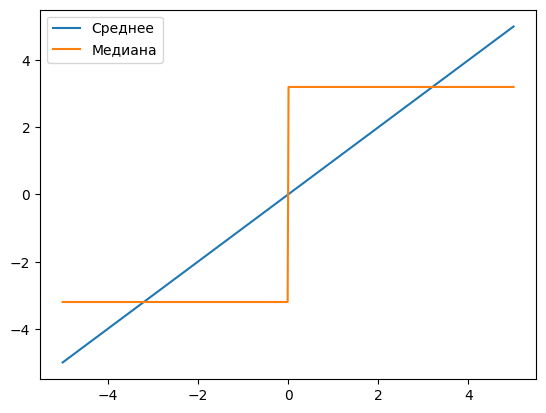

In [17]:
def IF_mean(data: np.ndarray, theta: float) -> np.ndarray:
    """
    Функция влиялия для среднего арифметического

    Args:
        data (np.ndarray): значения X распределения
        theta (float): параметр тетта смещения

    Returns:
        np.ndarray: значения функции влияния
    """
    return data - theta

def IF_median(data: np.ndarray, theta: float, lamb: float) -> np.ndarray:
    """
    Функция влиялия для медианы

    Args:
        data (np.ndarray): значения X распределения
        theta (float): параметр тетта смещения
        lamd (float): параметр лямбда распределения

    Returns:
        np.ndarray: значения функции влияния
    """
    return 16 * lamb * np.sign(data - theta) / 5

x = np.linspace(-5, 5, 500)

fig, axes = plt.subplots()

axes.plot(x, IF_mean(x, 0), label="Среднее")
axes.plot(x, IF_median(x, 0, 1), label="Медиана")
axes.legend()

plt.show()

### 4.2. Графики для усечённого среднего

Функция влияния усечённого среднего имеет следующий вид:

$$
\large
\text{IF}(y) = \frac{1}{1 - 2\alpha} \begin{cases}
-q,~\frac{y - \theta}{\lambda} < -q \\
\frac{y - \theta}{\lambda}, \left| \frac{y - \theta}{\lambda} \right| \leqslant q, \\
q, \frac{y - \theta}{\lambda} > q,
\end{cases}
$$

где $q$ – квантиль порядка $1 - \alpha$ стандартного распределения, то есть,

$$
\int_{-\infty}^{q} f(y) dy = 1 - \alpha,
$$

а $\alpha$ – уровень усечения ($\alpha = \{0.05, 0.10, 0.15\}$).

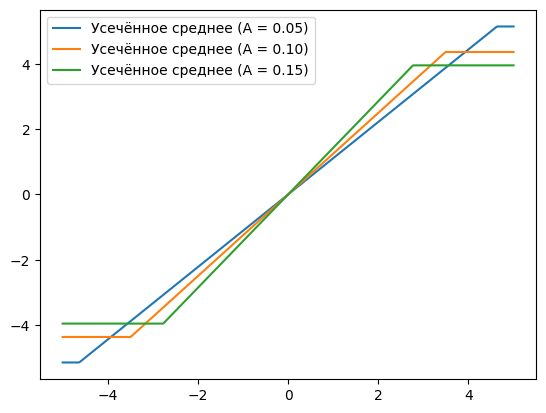

In [18]:
def IF_trim_mean(data: np.ndarray, alpha: float, theta: float, lamb: float) -> np.ndarray:
    """
    Функция влиялия для усечённого среднего

    Args:
        data (np.ndarray): значения X распределения
        alpha (float): параметр усечения (в диапазоне 0 <= alpha < 0.5)
        theta (float): параметр тетта смещения
        lamd (float): параметр лямбда распределения

    Returns:
        np.ndarray: значения функции влияния
    """
    # Определяем параметр q
    right = 1 - alpha
    fn = lambda x: np.exp(-1 * np.abs(x)) * (np.abs(x)**3 + 6 * np.abs(x)**2 + 15*np.abs(x) + 15) / 96
    fn_m = lambda q: np.abs(right - quad(fn, -np.inf, q)[0])
    q = minimize(fn_m, x0=2).x[0]

    # Считаем
    left = 1 / (1 - 2 * alpha) # Базовый множитель
    x = (data - theta) / lamb # преобразованная переменная y (массив)
    res = np.ndarray(x.shape) # Результат
    for i in range(x.size):
        if x[i] < -q:
            res[i] = -q
        elif x[i] > q:
            res[i] = q
        else:
            res[i] = x[i]
    return left * res

x = np.linspace(-5, 5, 500)

fig, axes = plt.subplots()
axes.plot(x, IF_trim_mean(x, 0.05, 0, 1), label="Усечённое среднее (A = 0.05)")
axes.plot(x, IF_trim_mean(x, 0.1, 0, 1), label="Усечённое среднее (A = 0.10)")
axes.plot(x, IF_trim_mean(x, 0.15, 0, 1), label="Усечённое среднее (A = 0.15)")
axes.legend()

plt.show()

### 4.3. Графики для метода максимального правдоподобия

Для максимального правдоподобия функция влияния задаётся следующим образом:

$$
\text{IF}(y) = \frac{-\lambda f'(\frac{y-\theta}{\lambda})/f(\frac{y - \theta}{\lambda})}{\int_{-\infty}^{+\infty}[f'(z)]^{2}/f(z)~dz}
$$

Производная функции $f$ равна

$$
\frac{df}{dx} = -xe^{-|x|}\frac{\left( |x|^2 + 3|x| + 3 \right) }{96}.
$$


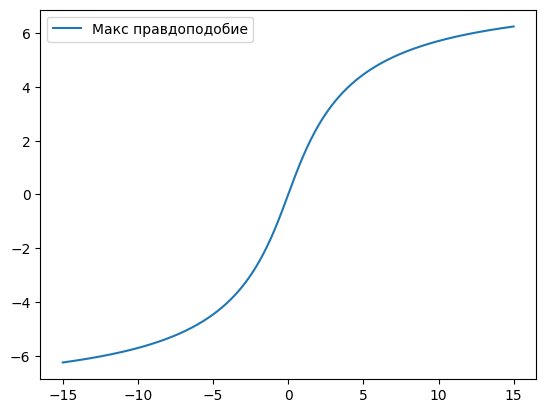

In [19]:
def IF_MLE(data: np.ndarray, theta: float, lamb: float) -> np.ndarray:
    """
    Функция влиялия для метода максимального правдоподобия

    Args:
        data (np.ndarray): значения X распределения
        theta (float): параметр тетта смещения
        lamd (float): параметр лямбда распределения

    Returns:
        np.ndarray: значения функции влияния
    """
    fn = lambda x: np.exp(-1 * np.abs(x)) * (np.abs(x)**3 + 6 * np.abs(x)**2 + 15*np.abs(x) + 15) / 96
    dfn = lambda x: -1 * x * np.exp(-1 * np.abs(x)) * (np.abs(x)**2 + 3*np.abs(x) + 3) / 96
    fndfn = lambda x: dfn(x)**2 / fn(x)

    denumenator = quad(fndfn, -700, 700)[0] # По идее надо -np.inf; np.inf, но там всё ломается
    x = (data - theta) / lamb

    return -lamb / denumenator * dfn(x) / fn(x)

x = np.linspace(-15, 15, 500)

fig, axes = plt.subplots()
axes.plot(x, IF_MLE(x, 0, 1), label="Макс правдоподобие")
axes.legend()

plt.show()


### 4.4. Графики для метода обобщённых радикальных оценок

Для обобщённых радикальных оценок функция влияния задаётся следующим образом:

$$
\text{IF}(y) = \frac{-\lambda f'(\frac{y-\theta}{\lambda})f^{\delta - 1}(\frac{y - \theta}{\lambda})}{\int_{-\infty}^{+\infty}[f'(z)]^{2} f^{\delta - 1}(z)~dz}
$$

Производная функции $f$ равна

$$
\frac{df}{dx} = -e^{-|x|}\frac{\left( |x|^2 + 3|x| + 3 \right) }{96}.
$$

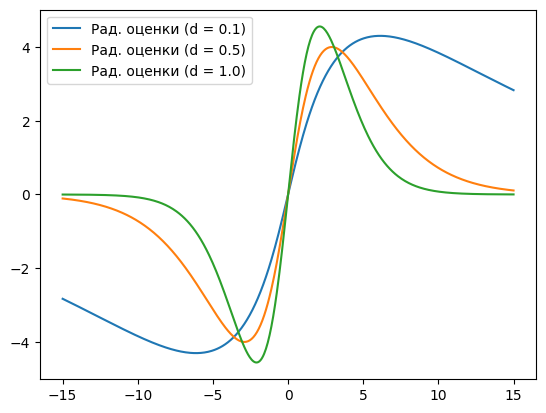

In [20]:
def IF_MGD(data: np.ndarray, delta: float, theta: float, lamb: float) -> np.ndarray:
    """
    Функция влиялия для метода обобщённых радикальных оценок

    Args:
        data (np.ndarray): значения X распределения
        delta (float): параметр регулировки степени робастности оценки
        theta (float): параметр тетта смещения
        lamd (float): параметр лямбда распределения

    Returns:
        np.ndarray: значения функции влияния
    """
    fn = lambda x: np.exp(-1 * np.abs(x)) * (np.abs(x)**3 + 6 * np.abs(x)**2 + 15*np.abs(x) + 15) / 96
    dfn = lambda x: -1 * x * np.exp(-1 * np.abs(x)) * (np.abs(x)**2 + 3*np.abs(x) + 3) / 96
    fndfn = lambda x: dfn(x)**2 * fn(x)**(delta - 1)

    denumenator = quad(fndfn, -700, 700)[0] # По идее надо -np.inf; np.inf, но там всё ломается
    x = (data - theta) / lamb

    return -lamb / denumenator * dfn(x) * fn(x)**(delta - 1)

x = np.linspace(-15, 15, 500)

fig, axes = plt.subplots()
axes.plot(x, IF_MGD(x, 0.1, 0, 1), label="Рад. оценки (d = 0.1)")
axes.plot(x, IF_MGD(x, 0.5, 0, 1), label="Рад. оценки (d = 0.5)")
axes.plot(x, IF_MGD(x, 1.0, 0, 1), label="Рад. оценки (d = 1.0)")
axes.legend()

plt.show()

### 4.5. Графики функций влияния всех оценок

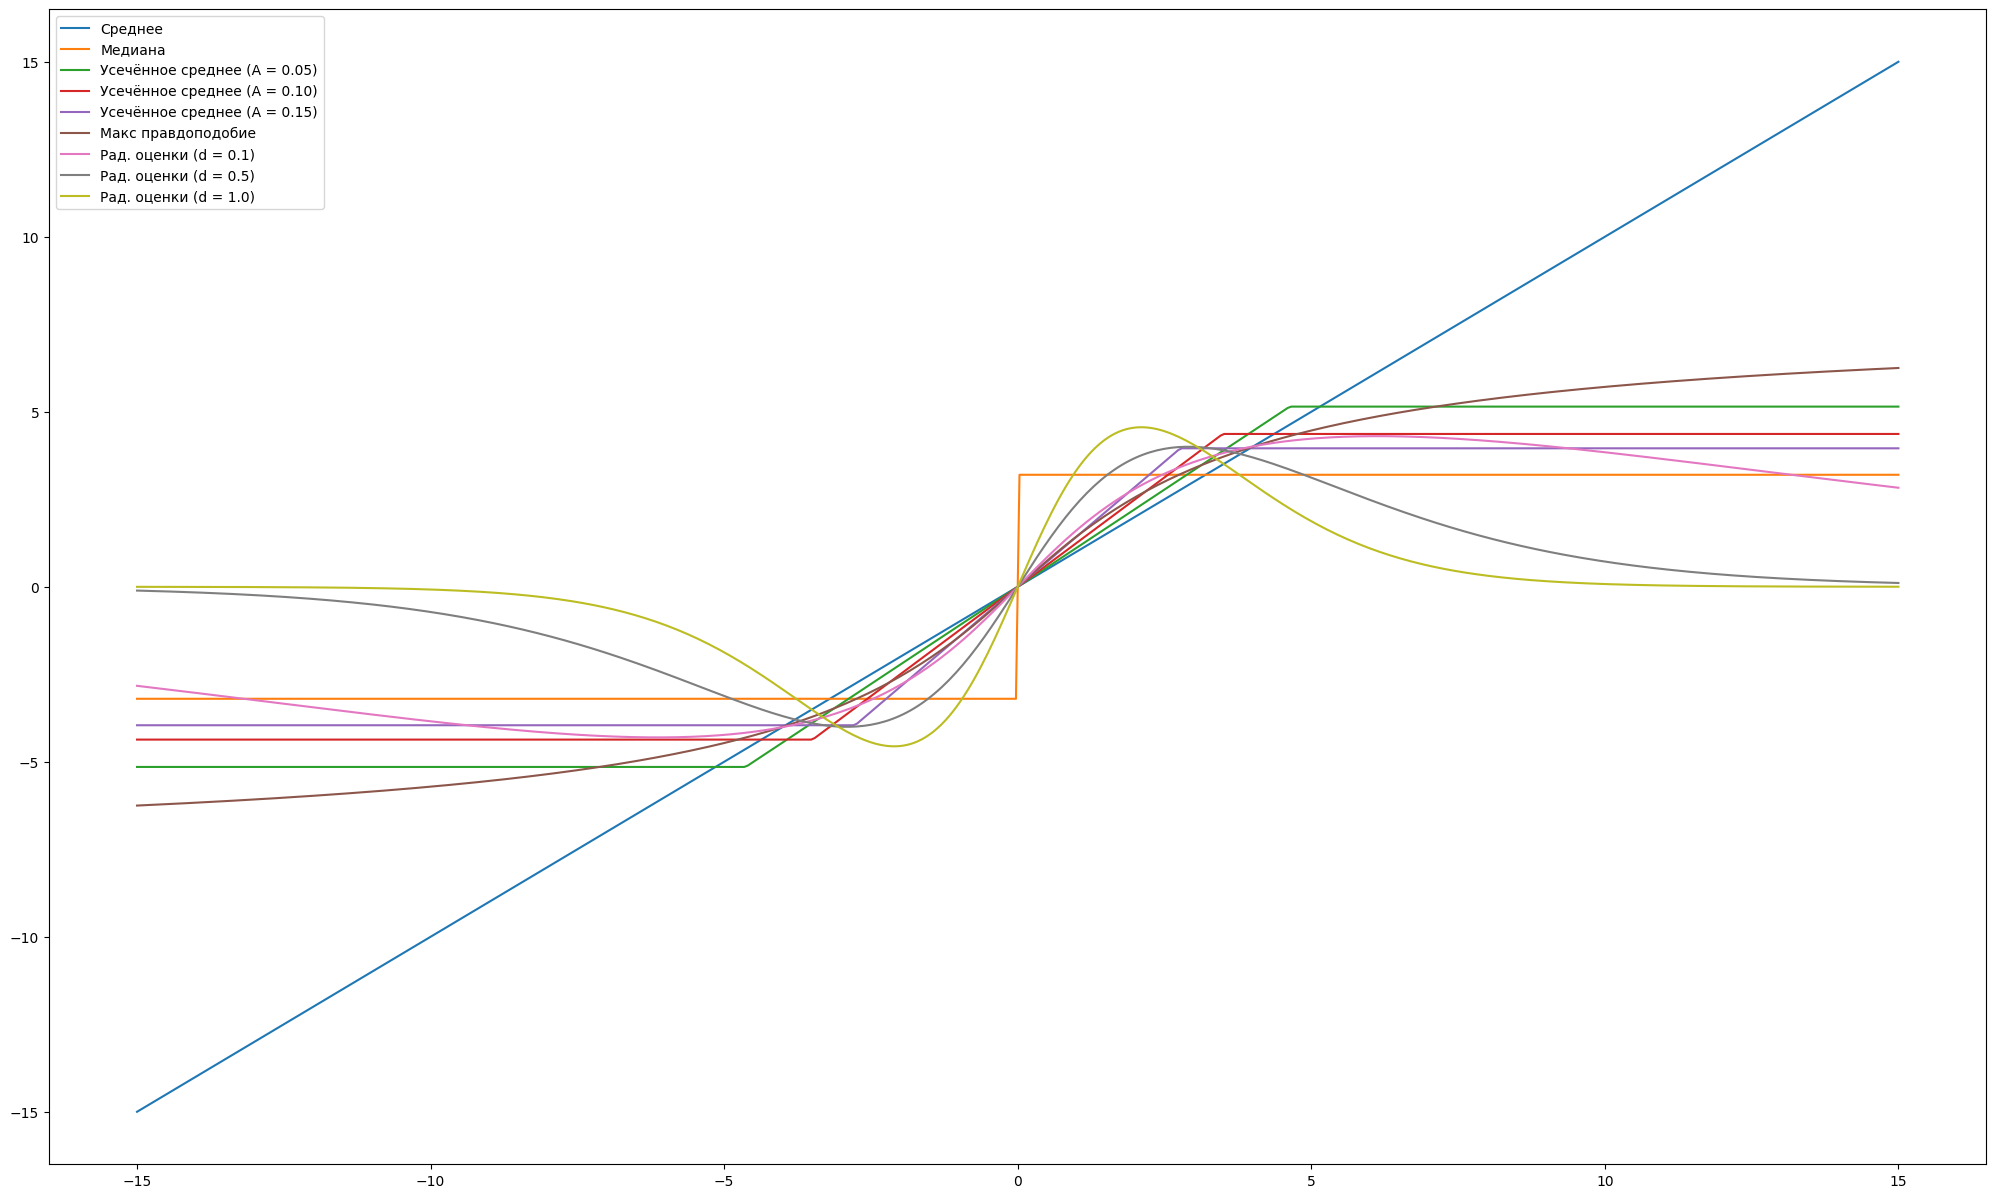

In [21]:
x = np.linspace(-15, 15, 500)

fig, axes = plt.subplots(figsize=(25,15))
axes.plot(x, IF_mean(x, 0), label="Среднее")
axes.plot(x, IF_median(x, 0, 1), label="Медиана")
axes.plot(x, IF_trim_mean(x, 0.05, 0, 1), label="Усечённое среднее (A = 0.05)")
axes.plot(x, IF_trim_mean(x, 0.1, 0, 1), label="Усечённое среднее (A = 0.10)")
axes.plot(x, IF_trim_mean(x, 0.15, 0, 1), label="Усечённое среднее (A = 0.15)")
axes.plot(x, IF_MLE(x, 0, 1), label="Макс правдоподобие")
axes.plot(x, IF_MGD(x, 0.1, 0, 1), label="Рад. оценки (d = 0.1)")
axes.plot(x, IF_MGD(x, 0.5, 0, 1), label="Рад. оценки (d = 0.5)")
axes.plot(x, IF_MGD(x, 1.0, 0, 1), label="Рад. оценки (d = 1.0)")
axes.legend()

plt.show()